# Build a Comment Toxicity Model with Deep Learning and Python

# import dependencies:

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization

In [2]:
df=pd.read_csv('twitter_parsed_dataset.csv')

In [3]:
df.head()

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0


In [4]:
df.columns

Index(['index', 'id', 'Text', 'Annotation', 'oh_label'], dtype='object')

In [5]:
df['oh_label'].unique()

array([ 0.,  1., nan])

In [6]:
df['oh_label'].value_counts()

0.0    11501
1.0     5347
Name: oh_label, dtype: int64

In [7]:
df['Annotation'].unique()

array(['none', 'sexism', 'racism', nan], dtype=object)

In [8]:
df['Annotation'].value_counts()

none      11501
sexism     3377
racism     1970
Name: Annotation, dtype: int64

In [9]:
print(df['Text'][3])

@g0ssipsquirrelx Wrong, ISIS follows the example of Mohammed and the Quran exactly.


In [10]:
df.shape

(16851, 5)

# data preprocessing

In [11]:
df=df.iloc[:,2:]

In [12]:
df.columns

Index(['Text', 'Annotation', 'oh_label'], dtype='object')

In [13]:
(df.isna()==True).sum()

Text          1
Annotation    3
oh_label      3
dtype: int64

In [14]:
df=df.dropna()

In [22]:
(df.isna()).sum()

Text                 0
oh_label             0
Annotation_none      0
Annotation_racism    0
Annotation_sexism    0
dtype: int64

In [16]:
df = pd.concat([df, pd.get_dummies(df['Annotation'], prefix='Annotation')], axis=1)
df.drop('Annotation', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16848 entries, 0 to 16850
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Text               16848 non-null  object 
 1   oh_label           16848 non-null  float64
 2   Annotation_none    16848 non-null  uint8  
 3   Annotation_racism  16848 non-null  uint8  
 4   Annotation_sexism  16848 non-null  uint8  
dtypes: float64(1), object(1), uint8(3)
memory usage: 444.2+ KB


In [17]:
df

,Text,oh_label,Annotation_none,Annotation_racism,Annotation_sexism
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,1,0,0
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,1,0,0
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,0,0,1
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,0,1,0
4,#mkr No No No No No No,0.0,1,0,0
...,...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,1,0,0
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,1,0,0
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,1,0,0
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,1,0,0


In [18]:
Y=df.iloc[:,1:]

In [19]:
Y

,oh_label,Annotation_none,Annotation_racism,Annotation_sexism
0,0.0,1,0,0
1,0.0,1,0,0
2,1.0,0,0,1
3,1.0,0,1,0
4,0.0,1,0,0
...,...,...,...,...
16846,0.0,1,0,0
16847,0.0,1,0,0
16848,0.0,1,0,0
16849,0.0,1,0,0


In [20]:
Y.shape

(16848, 4)

In [21]:
import re
import string
def remove_spec(text):
    text = re.sub('<.*?>+', '', text)
    text = text.lower()
    return text

# Rmoving puntuctions

def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

# Removing URL

def remove_urls(text):
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+",'',text)
    return text
# Removing Emojis

def remove_emoji(text):
    emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = re.sub(emojis,'',text)
    return text

In [25]:
df['cleaned_text'] = df['Text'].astype(str).apply(lambda x : remove_punctuation(x))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x : remove_urls(x))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x : remove_emoji(x))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x : remove_spec(x))


In [51]:
X=df['cleaned_text']

In [52]:
X

0        halalflaws biebervalue greenlinerzjm i read th...
1        shreyabafna3 now you idiots claim that people ...
2        rt mooseoftorment call me sexist but when i go...
3        g0ssipsquirrelx wrong isis follows the example...
4                                    mkr no no no no no no
                               ...                        
16846    feeling so sorry for the girls they should be ...
16847    mkr pretty good dishes were happy with  ok wel...
16848    rt colonelkickhead deconstructed lemon tartcan...
16849    versacezaynx nyazpolitics greenlinerzjm you ar...
16850    and before you protest that youre not mad ther...
Name: cleaned_text, Length: 16848, dtype: object

In [53]:
X.shape

(16848,)

In [54]:
Y.shape

(16848, 4)

In [56]:
len(X[1])

137

In [48]:
from tensorflow.keras.layers import TextVectorization

In [57]:
max_feature=17000
vectorizer=TextVectorization(max_tokens=max_feature,
                             output_sequence_length=200,
                             output_mode='int'
                            )

In [58]:
vectorizer.adapt(X.values)

In [59]:
vectorized_text=vectorizer(X.values)

In [60]:
len(X)

16848

In [61]:
vectorized_text

<tf.Tensor: shape=(16848, 200), dtype=int64, numpy=
array([[  253,   318,   181, ...,     0,     0,     0],
       [ 6020,    78,    11, ...,     0,     0,     0],
       [   10, 16374,   108, ...,     0,     0,     0],
       ...,
       [   10,  1440,   344, ...,     0,     0,     0],
       [ 1932,  1121,   181, ...,     0,     0,     0],
       [    7,   179,    11, ...,     0,     0,     0]], dtype=int64)>

In [62]:
data=tf.data.Dataset.from_tensor_slices((vectorized_text,Y))
data=data.cache()
data=data.shuffle(17000)
data=data.batch(16)
data=data.prefetch(8)

In [64]:
batch_x,batch_y=data.as_numpy_iterator().next()

In [65]:
batch_x.shape

(16, 200)

In [66]:
batch_y.shape

(16, 4)

In [67]:
train=data.take(int(len(data)*.7))
val=data.skip(int(len(data)*.7)).take(int(len(data)*.2))
test=data.skip(int(len(data)*.9)).take(int(len(data)*.1))

In [68]:
tain_generator=train.as_numpy_iterator()

In [70]:
tain_generator.next()

(array([[ 8004,   267,   275, ...,     0,     0,     0],
        [  123,   104,  3060, ...,     0,     0,     0],
        [   10,  3242,  8042, ...,     0,     0,     0],
        ...,
        [   10, 11319, 12470, ...,     0,     0,     0],
        [   35,    84,  2258, ...,     0,     0,     0],
        [   10, 10756,    34, ...,     0,     0,     0]], dtype=int64),
 array([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]]))

# Callback

In [94]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model Training

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Bidirectional,Dense,Embedding,Reshape

In [96]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.legacy import Adam

In [97]:
model = Sequential()

model.add(Embedding(max_feature+1,32))

model.add(Bidirectional(LSTM(32, activation='tanh')))

model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(4, activation='sigmoid'))


model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001) ,metrics=['accuracy'])


In [98]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          544032    
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 128)               8320      
                                                                 
 dense_19 (Dense)            (None, 256)               33024     
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                                 
 dense_21 (Dense)            (None, 4)                 516       
                                                      

In [99]:
X.shape

(16848,)

In [100]:
history=model.fit(train, epochs=5, validation_data=val,callbacks=[early_stopping])

Epoch 1/5
737/737 [==============================] - 78s 100ms/step - loss: 0.3966 - accuracy: 0.7908 - val_loss: 0.2506 - val_accuracy: 0.8414
Epoch 2/5
737/737 [==============================] - 73s 99ms/step - loss: 0.2202 - accuracy: 0.7920 - val_loss: 0.1768 - val_accuracy: 0.7503
Epoch 3/5
737/737 [==============================] - 73s 99ms/step - loss: 0.1610 - accuracy: 0.8109 - val_loss: 0.1152 - val_accuracy: 0.7402
Epoch 4/5
737/737 [==============================] - 74s 100ms/step - loss: 0.1166 - accuracy: 0.7869 - val_loss: 0.0811 - val_accuracy: 0.8536
Epoch 5/5
737/737 [==============================] - 73s 99ms/step - loss: 0.0902 - accuracy: 0.8520 - val_loss: 0.0764 - val_accuracy: 0.8976


<Figure size 200x3000 with 0 Axes>

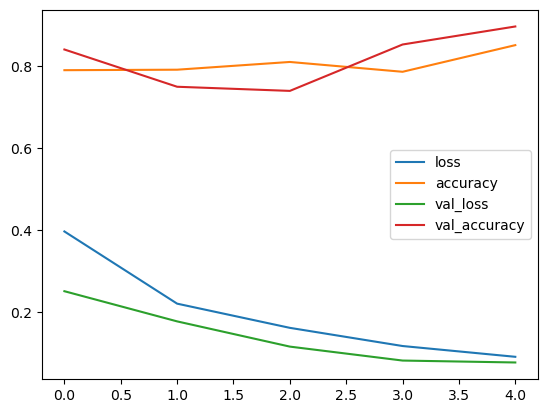

In [101]:
plt.figure(figsize=(2,30))
pd.DataFrame(history.history).plot()
plt.show()

# Prediction

In [104]:
text=vectorizer("Unfortunately, the product didn't live up to my expectations")

In [106]:
res=model.predict(np.expand_dims(text,0))

1/1 [==============================] - 3s 3s/step


In [107]:
res

array([[0.22681503, 0.77240086, 0.01660351, 0.20443815]], dtype=float32)

In [109]:
df.columns[1:]

Index(['oh_label', 'Annotation_none', 'Annotation_racism', 'Annotation_sexism',
       'cleaned_text'],
      dtype='object')

In [110]:
batch=test.as_numpy_iterator().next()

In [111]:
batch_X, batch_y = test.as_numpy_iterator().next()


In [113]:
batch_y

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

# Evaluate model

In [114]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [115]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [116]:
for batch in test.as_numpy_iterator(): 
    X_true, y_true = batch
    # Make a prediction 
    y_pred = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    pre.update_state(y_true, y_pred)
    re.update_state(y_true, y_pred)
    acc.update_state(y_true, y_pred)

1/1 [==============================] - 0s 47ms/step


In [117]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9677125811576843, Recall:0.9546881914138794, Accuracy:0.06666667014360428


The result is somewhat acceptable.

# 5-testand gradio

In [118]:
import gradio as gr

In [119]:
model.save('toxicity.h5')

C:\Users\Farah\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [120]:
model = tf.keras.models.load_model('toxicity.h5')

In [126]:
text=vectorizer('Arabs… have little or no knowledge of personal hygiene products such as deodorant or even soap')

In [127]:
res = model.predict(np.expand_dims(text,0))

1/1 [==============================] - 0s 51ms/step


In [128]:
res

array([[0.44722703, 0.5459528 , 0.0231856 , 0.4193006 ]], dtype=float32)

In [125]:
df.columns

Index(['Text', 'oh_label', 'Annotation_none', 'Annotation_racism',
       'Annotation_sexism', 'cleaned_text'],
      dtype='object')

In [150]:
import gradio as gr

def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[1:-1]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.Textbox(lines=3, placeholder='Comment to score'),
                        outputs='text')
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7872
Running on public URL: https://326284b481075d7e31.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 50ms/step
